### Data Preprocessing

In [0]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler, PCA, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, PCA, Bucketizer, VectorSlicer
from pyspark.ml import Pipeline
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay


In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("StrokePrediction").getOrCreate()

# File location and type
file_location = "/FileStore/tables/healthcare_dataset_stroke_data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df)

# Gender: existe um other, atribuir a Male ou Female ou então retirá-lo;
# Age: Há 115 valores decimais. São crianças. Passar para o valor acima ou então retirá-los. Têm todos stroke 0.
# bmi: 201 N/A. Retirar.
# Display the schema
#df.printSchema()

In [0]:
df = df.replace('N/A', None) # Substituir 'N/A' por null
df = df.filter(col("gender") != "Other") # Filter out rows where gender is "Other"
df = df.filter(col("bmi").isNotNull()) # Remove rows where bmi is null
df = df.filter((col("Age") % 1) == 0) # Keep only rows where age is a whole number

df = df.withColumn("id", col("id").cast(IntegerType()))
df = df.withColumn("gender", col("gender").cast(StringType()))
df = df.withColumn("age", col("age").cast(IntegerType()))
df = df.withColumn("hypertension", col("hypertension").cast(IntegerType()))
df = df.withColumn("heart_disease", col("heart_disease").cast(IntegerType()))
df = df.withColumn("ever_married", col("ever_married").cast(StringType()))
df = df.withColumn("work_type", col("work_type").cast(StringType()))
df = df.withColumn("Residence_type", col("Residence_type").cast(StringType()))
df = df.withColumn("avg_glucose_level", col("avg_glucose_level").cast(DoubleType()))
df = df.withColumn("bmi", col("bmi").cast(DoubleType()))
df = df.withColumn("smoking_status", col("smoking_status").cast(StringType()))
df = df.withColumn("stroke", col("stroke").cast(IntegerType()))
df = df.drop("id") # Drop column "id"
#display(df)

numerical_cols = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
df.describe(numerical_cols).display()


summary age hypertension heart_disease avg_glucose_level bmi stroke count 4799 4799 4799 4799 4799 4799 mean 43.8170452177537 0.09397791206501355 0.05063554907272348 105.52133361116864 29.132652635965847 0.043550739737445304 stddev 21.905150825807425 0.29182839181015746 0.21927519087229563 44.69377368194213 7.767762301041014 0.20411456183945606 min 1 0 0 55.12 11.3 0 max 82 1 1 271.74 97.6 1

In [0]:
for i in categorical_cols:
    print(f"\nContagem de valores para a coluna '{i}':")
    df.groupBy(i).count().orderBy("count", ascending=False).show()


Contagem de valores para a coluna 'gender':
+------+-----+
|gender|count|
+------+-----+
|Female| 2842|
|  Male| 1957|
+------+-----+


Contagem de valores para a coluna 'ever_married':
+------------+-----+
|ever_married|count|
+------------+-----+
|         Yes| 3204|
|          No| 1595|
+------------+-----+


Contagem de valores para a coluna 'work_type':
+-------------+-----+
|    work_type|count|
+-------------+-----+
|      Private| 2810|
|Self-employed|  775|
|     Govt_job|  630|
|     children|  562|
| Never_worked|   22|
+-------------+-----+


Contagem de valores para a coluna 'Residence_type':
+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2434|
|         Rural| 2365|
+--------------+-----+


Contagem de valores para a coluna 'smoking_status':
+---------------+-----+
| smoking_status|count|
+---------------+-----+
|   never smoked| 1852|
|        Unknown| 1374|
|formerly smoked|  836|
|         smokes|  737|
+---------------+-----+



In [0]:
df.groupBy("stroke").count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  209|
|     0| 4590|
+------+-----+



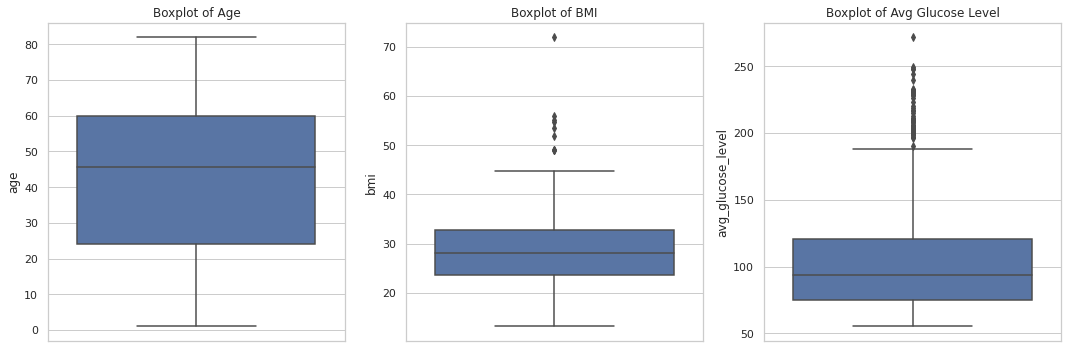

In [0]:
# Check the outliers
# Convert full or sampled data to Pandas for plotting
df_pd = df.select("age", "bmi", "avg_glucose_level").sample(fraction=0.1).toPandas()

# Set the plot style
sns.set(style="whitegrid")

# Create subplots
plt.figure(figsize=(15, 5))

# Boxplot for age
plt.subplot(1, 3, 1)
sns.boxplot(y=df_pd["age"])
plt.title("Boxplot of Age")

# Boxplot for bmi
plt.subplot(1, 3, 2)
sns.boxplot(y=df_pd["bmi"])
plt.title("Boxplot of BMI")

# Boxplot for avg_glucose_level
plt.subplot(1, 3, 3)
sns.boxplot(y=df_pd["avg_glucose_level"])
plt.title("Boxplot of Avg Glucose Level")

plt.tight_layout()
plt.show()


In [0]:
df_cleaned = df.filter(col("bmi") <= 60).filter(col("avg_glucose_level") <= 260)
before_count = df.count()
after_count = df_cleaned.count()
removed = before_count - after_count
percent_removed = removed / before_count * 100
print(f"Removed {removed} rows ({percent_removed:.2f}%) based on domain-specific outlier rules.")
display(df_cleaned)

Removed 21 rows (0.44%) based on domain-specific outlier rules.


gender age hypertension heart_disease ever_married work_type Residence_type avg_glucose_level bmi smoking_status stroke Male 67 0 1 Yes Private Urban 228.69 36.6 formerly smoked 1 Male 80 0 1 Yes Private Rural 105.92 32.5 never smoked 1 Female 49 0 0 Yes Private Urban 171.23 34.4 smokes 1 Female 79 1 0 Yes Self-employed Rural 174.12 24.0 never smoked 1 Male 81 0 0 Yes Private Urban 186.21 29.0 formerly smoked 1 Male 74 1 1 Yes Private Rural 70.09 27.4 never smoked 1 Female 69 0 0 No Private Urban 94.39 22.8 never smoked 1 Female 78 0 0 Yes Private Urban 58.57 24.2 Unknown 1 Female 81 1 0 Yes Private Rural 80.43 29.7 never smoked 1 Female 61 0 1 Yes Govt_job Rural 120.46 36.8 smokes 1 Female 54 0 0 Yes Private Urban 104.51 27.3 smokes 1 Female 79 0 1 Yes Private Urban 214.09 28.2 never smoked 1 Female 50 1 0 Yes Self-employed Rural 167.41 30.9 never smoked 1 Male 64 0 1 Yes Private Urban 191.61 37.5 smokes 1 Male 75 1 0 Yes Private Urban 221.29 25.8 smokes 1 Female 60 0 0 No Private Urban 89.22 37.8 never smoked 1 Female 71 0 0 Yes Govt_job Rural 193.94 22.4 smokes 1 Female 52 1 0 Yes Self-employed Urban 233.29 48.9 never smoked 1 Female 79 0 0 Yes Self-employed Urban 228.7 26.6 never smoked 1 Male 82 0 1 Yes Private Rural 208.3 32.5 Unknown 1 Male 71 0 0 Yes Private Urban 102.87 27.2 formerly smoked 1 Male 80 0 0 Yes Self-employed Rural 104.12 23.5 never smoked 1 Female 65 0 0 Yes Private Rural 100.98 28.2 formerly smoked 1 Male 69 0 1 Yes Self-employed Urban 195.23 28.3 smokes 1 Male 57 1 0 Yes Private Urban 212.08 44.2 smokes 1 Male 42 0 0 Yes Private Rural 83.41 25.4 Unknown 1 Female 82 1 0 Yes Self-employed Urban 196.92 22.2 never smoked 1 Male 80 0 1 Yes Self-employed Urban 252.72 30.5 formerly smoked 1 Male 48 0 0 No Govt_job Urban 84.2 29.7 never smoked 1 Female 82 1 1 No Private Rural 84.03 26.5 formerly smoked 1 Male 74 0 0 Yes Private Rural 219.72 33.7 formerly smoked 1 Female 72 1 0 Yes Private Rural 74.63 23.1 formerly smoked 1 Male 58 0 0 No Private Rural 92.62 32.0 Unknown 1 Female 49 0 0 Yes Private Urban 60.91 29.9 never smoked 1 Male 78 0 0 Yes Private Rural 78.03 23.9 formerly smoked 1 Male 54 0 0 Yes Private Urban 71.22 28.5 never smoked 1 Male 82 0 1 Yes Private Urban 144.9 26.4 smokes 1 Male 60 1 0 Yes Govt_job Urban 213.03 20.2 smokes 1 Male 76 1 0 Yes Private Rural 243.58 33.6 never smoked 1 Female 58 0 0 Yes Private Urban 107.26 38.6 formerly smoked 1 Male 81 0 0 Yes Self-employed Urban 99.33 33.7 never smoked 1 Female 39 1 0 Yes Private Rural 58.09 39.2 smokes 1 Female 79 0 1 Yes Private Rural 127.29 27.7 never smoked 1 Female 77 1 0 Yes Self-employed Urban 124.13 31.4 never smoked 1 Male 63 0 1 Yes Private Rural 196.71 36.5 formerly smoked 1 Female 82 0 0 Yes Private Rural 59.32 33.2 never smoked 1 Male 73 1 0 Yes Self-employed Urban 194.99 32.8 never smoked 1 Female 54 1 0 Yes Govt_job Urban 180.93 27.7 never smoked 1 Female 56 0 0 Yes Private Urban 185.17 40.4 formerly smoked 1 Female 80 1 0 Yes Private Rural 74.9 22.2 never smoked 1 Female 67 1 0 Yes Self-employed Rural 61.94 25.3 smokes 1 Female 45 0 0 Yes Private Rural 93.72 30.2 formerly smoked 1 Male 78 1 0 No Private Urban 113.01 24.0 never smoked 1 Female 70 0 0 Yes Private Urban 221.58 47.5 never smoked 1 Male 76 0 0 Yes Private Urban 104.47 20.3 Unknown 1 Male 59 0 0 Yes Private Urban 86.23 30.0 formerly smoked 1 Female 80 1 0 Yes Self-employed Rural 72.67 28.9 never smoked 1 Female 67 1 0 Yes Private Rural 179.12 28.1 formerly smoked 1 Female 66 1 0 Yes Govt_job Rural 116.55 31.1 formerly smoked 1 Male 63 0 0 Yes Private Rural 228.56 27.4 never smoked 1 Female 52 0 0 Yes Private Rural 96.59 26.4 never smoked 1 Female 80 0 1 Yes Self-employed Rural 66.72 21.7 formerly smoked 1 Male 80 1 0 Yes Private Urban 240.09 27.0 never smoked 1 Female 79 0 0 Yes Private Urban 110.85 24.1 formerly smoked 1 Male 43 0 0 Yes Self-employed Urban 143.43 45.9 Unknown 1 Male 59 0 0 Yes Private Rural 96.16 44.1 Unknown 1 Female 79 0 0 No Private Rural 88.92 22.

In [0]:
# Categorical columns
binary_cat_cols = ['gender', 'ever_married', 'Residence_type']
nominal_cat_cols = ['work_type', 'smoking_status']

# Numerical columns to scale
numeric_cols = ['age', 'avg_glucose_level', 'bmi']

# Target column
label_col = 'stroke'

# 1. StringIndexers
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in binary_cat_cols + nominal_cat_cols]

# 2. OneHotEncoders for nominal features only
onehots = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_ohe") for col in nominal_cat_cols]

# 3. Vector assembler for numeric features (before scaling)
num_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_vector")

# 4. Standard scaler for numerical features
scaler = StandardScaler(inputCol="numeric_vector", outputCol="scaled_numeric_vector", withMean=True, withStd=True)

# 5. Final feature vector assembly
assembler_inputs = [f"{col}_index" for col in binary_cat_cols] + \
                   [f"{col}_ohe" for col in nominal_cat_cols] + \
                   ["scaled_numeric_vector"]

final_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# 6. Build pipeline
pipeline = Pipeline(stages=indexers + onehots + [num_assembler, scaler, final_assembler])

# 7. Fit and transform the data
pipeline_model = pipeline.fit(df_cleaned)
df_preprocessed = pipeline_model.transform(df_cleaned)

In [0]:
df_final = df_preprocessed.select("features", "stroke")
df_final.show(truncate=False)
display(df_final)

+----------------------------------------------------------------------------------------------------+------+
|features                                                                                            |stroke|
+----------------------------------------------------------------------------------------------------+------+
|(15,[0,3,10,12,13,14],[1.0,1.0,1.0,1.0591837211513395,2.7896732263365522,1.015763014884945])        |1     |
|(15,[0,2,3,8,12,13,14],[1.0,1.0,1.0,1.0,1.6522830635561285,0.014836419543762242,0.4664286313287891])|1     |
|(15,[3,11,12,13,14],[1.0,1.0,0.2379692470524012,1.4909673297957544,0.7209982237084709])             |1     |
|(15,[2,4,8,12,13,14],[1.0,1.0,1.0,1.6066600372172986,1.5562868571365642,-0.6724353345803142])       |1     |
|(15,[0,3,10,12,13,14],[1.0,1.0,1.0,1.6979060898949583,1.8295439801643791,-0.0025153546337828357])   |1     |
|(15,[0,2,3,8,12,13,14],[1.0,1.0,1.0,1.0,1.378544905523149,-0.7949901080068256,-0.21688974821667306])|1     |
|(15,[1,3,

features stroke Map(vectorType -> sparse, length -> 15, indices -> List(0, 3, 10, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.0591837211513395, 2.7896732263365522, 1.015763014884945)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 2, 3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.0, 1.6522830635561285, 0.014836419543762242, 0.4664286313287891)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(3, 11, 12, 13, 14), values -> List(1.0, 1.0, 0.2379692470524012, 1.4909673297957544, 0.7209982237084709)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 4, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.6066600372172986, 1.5562868571365642, -0.6724353345803142)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 3, 10, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.6979060898949583, 1.8295439801643791, -0.0025153546337828357)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 2, 3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.0, 1.378544905523149, -0.7949901080068256, -0.21688974821667306)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(1, 3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.1504297738289995, -0.24576363244223492, -0.8332161297674816)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(3, 9, 12, 13, 14), values -> List(1.0, 1.0, 1.5610370108784686, -1.055364140867076, -0.6456385353824531)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.6979060898949583, -0.561286331984691, 0.09127344255873146)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 5, 11, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 0.7854455631183601, 0.3434682283795295, 1.0425598140828056)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(3, 11, 12, 13, 14), values -> List(1.0, 1.0, 0.46608437874655073, -0.017032277186528746, -0.2302881478156034)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.6066600372172986, 2.4596853027463044, -0.10970255142522795)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 4, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 0.2835922733912311, 1.404628023760498, 0.2520542377458989)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 3, 11, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 0.9223146421348498, 1.9515943080676217, 1.1363486112753205)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 3, 11, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.4241679318619789, 2.622419073283961, -0.4312641417995628)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(1, 3, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 0.7398225367795302, -0.3626155204533022, 1.176543810072112)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 5, 11, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.2416758265066592, 2.004256764366613, -0.8868097281632044)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(4, 8, 12, 13, 14), values -> List(1.0, 1.0, 0.3748383260688909, 2.893642024180055, 2.6637661655534117)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(4, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.6066600372172986, 2.789899245462299, -0.3240769450081177)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 2, 3, 9, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.0, 1.7435291162337883, 2.3288202289389393, 0.4664286313287891)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 3, 10, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.2416758265066592, -0.05409941380899496, -0.24368654741453422)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(0, 2, 4, 8, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 1.0, 1.6522830635561285, -0.02584702309065182, -0.7394273325749673)) 1 Map(vectorType -> sparse, length -> 15, indices -> List(2, 3, 10, 12, 13, 14), values -> List(1.0, 1.0, 1.0, 0.9679376684736798, -0.0968170285751298, -0.10970255142522795)) 1 Map(vectorType -> sparse, len

In [0]:
def evaluate_model(predictions, label_col="stroke", prediction_col="prediction"):
    """
    Evaluate a classification model using AUC, accuracy, confusion matrix,
    precision, recall, and F1 score.

    Parameters:
        predictions (DataFrame): Spark DataFrame with prediction results
        label_col (str): Name of the label column
        prediction_col (str): Name of the prediction column
    """
    # AUC
    evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)
    print(f"Model AUC: {auc:.6f}")

    # Accuracy
    acc_evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")
    accuracy = acc_evaluator.evaluate(predictions)
    print(f"Accuracy: {accuracy:.6f}")

    # Confusion Matrix
    tp = predictions.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()
    tn = predictions.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()
    fp = predictions.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()
    fn = predictions.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()

    print(f"\nConfusion Matrix:")
    print(f"TP: {tp}  FP: {fp}")
    print(f"FN: {fn}  TN: {tn}")

    # Precision, Recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nPrecision: {precision:.6f}")
    print(f"Recall:    {recall:.6f}")
    print(f"F1 Score:  {f1_score:.6f}")


### Feature Selection

In [0]:
# 1. Fit Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="stroke", numTrees=100)
rf_model = rf.fit(df_final)

# 2. Get feature importances
importances = rf_model.featureImportances

# 3. Convert SparseVector to list of (index, importance)
feature_importance_list = list(zip(range(len(importances)), importances.toArray()))
sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# 4. Show top N important features
top_n = 10
print(f"\nTop {top_n} features by importance:")
for i, (idx, score) in enumerate(sorted_features[:top_n]):
    print(f"Rank {i+1}: Feature Index {idx}, Importance {score:.6f}")


Top 10 features by importance:
Rank 1: Feature Index 12, Importance 0.408843
Rank 2: Feature Index 13, Importance 0.227643
Rank 3: Feature Index 14, Importance 0.154136
Rank 4: Feature Index 1, Importance 0.056829
Rank 5: Feature Index 9, Importance 0.022738
Rank 6: Feature Index 4, Importance 0.022283
Rank 7: Feature Index 10, Importance 0.020019
Rank 8: Feature Index 6, Importance 0.016838
Rank 9: Feature Index 0, Importance 0.016512
Rank 10: Feature Index 3, Importance 0.014703


In [0]:
selected_indices = [idx for idx, _ in sorted_features[:top_n]]

slicer = VectorSlicer(inputCol="features", outputCol="selectedFeatures", indices=selected_indices)
df_sliced = slicer.transform(df_final).select("selectedFeatures", "stroke")

In [0]:
# Calculate fraction of positive and negative classes
total_count = df_sliced.count()
positive_count = df_sliced.filter(col("stroke") == 1).count()
negative_count = total_count - positive_count

# Compute weights for each class: weight = total_count / (2 * count_in_class)
pos_weight = total_count / (2 * positive_count)
neg_weight = total_count / (2 * negative_count)

# Add weight column to df_final
df_sliced = df_sliced.withColumn("weight", when(col("stroke") == 1, pos_weight).otherwise(neg_weight))

# Split data
train_data, test_data = df_sliced.randomSplit([0.8, 0.2], seed=42)

### Hyperparameter tuning with weightCol on Logistic Regression

In [0]:
# Instantiate logistic regression with weightCol
lr = LogisticRegression(featuresCol="selectedFeatures", 
                        labelCol="stroke", 
                        weightCol="weight")

# Define evaluator - binary classification metrics like areaUnderROC
evaluator = BinaryClassificationEvaluator(labelCol="stroke", metricName="areaUnderROC")

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.2, 0.5])           # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 0.75, 1.0])     # 0 = L2, 1 = L1, 0.5 = elastic net
             .addGrid(lr.maxIter, [10, 25, 50, 75, 100])                # max iterations
             .build())

# CrossValidator setup
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=4,             # 4-fold CV
                          parallelism=2)          # adjust parallelism based on your cluster

# Fit the model
cvModel = crossval.fit(train_data)

# Best Model
bestModel = cvModel.bestModel

# Print best hyperparameters
print(f"Best regParam: {bestModel._java_obj.getRegParam()}")
print(f"Best elasticNetParam: {bestModel._java_obj.getElasticNetParam()}")
print(f"Best maxIter: {bestModel._java_obj.getMaxIter()}")

# Make predictions on the same or test data
predictions = bestModel.transform(test_data)

# Evaluation
evaluate_model(predictions, label_col="stroke", prediction_col="prediction")

Best regParam: 0.1
Best elasticNetParam: 0.5
Best maxIter: 10
Model AUC: 0.833069
Accuracy: 0.671772

Confusion Matrix:
TP: 28  FP: 298
FN: 2  TN: 586

Precision: 0.085890
Recall:    0.933333
F1 Score:  0.157303


###  Hyperparameter tuning with weightCol on Random Forest

In [0]:
# 1. Instantiate Random Forest with weightCol
rf = RandomForestClassifier(
    labelCol="stroke", 
    featuresCol="selectedFeatures", 
    weightCol="weight",
    seed=42
)

# 2. Define evaluator for binary classification (AUC)
evaluator = BinaryClassificationEvaluator(
    labelCol="stroke", 
    metricName="areaUnderROC"
)

# 3. Define ParamGrid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 150])     # number of trees
             .addGrid(rf.maxDepth, [4, 6, 8, 10])       # tree depth
             .addGrid(rf.maxBins, [32, 64])             # binning for continuous features
             .build())

# 4. CrossValidator setup
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=4,
    parallelism=2   # adjust based on your system
)

# 5. Fit the model
cvModel = crossval.fit(train_data)

# 6. Extract best model
bestModel = cvModel.bestModel

print(f"Best numTrees: {bestModel.getNumTrees}")
print(f"Best maxDepth: {bestModel.getOrDefault('maxDepth')}")
print(f"Best maxBins: {bestModel.getOrDefault('maxBins')}")

# 7. Make predictions
predictions = bestModel.transform(test_data)

# 8. Evaluation
evaluate_model(predictions, label_col="stroke", prediction_col="prediction")

Best numTrees: 150
Best maxDepth: 4
Best maxBins: 64
Model AUC: 0.839145
Accuracy: 0.691466

Confusion Matrix:
TP: 37  FP: 278
FN: 4  TN: 595

Precision: 0.117460
Recall:    0.902439
F1 Score:  0.207865


### Hyperparameter tuning with weightCol on GBTClassifier

In [0]:
# 1. Instantiate GBTClassifier with weightCol
gbt = GBTClassifier(
    labelCol="stroke",
    featuresCol="selectedFeatures",
    weightCol="weight",  # class weights
    seed=42
)

# 2. Binary evaluator (AUC)
evaluator = BinaryClassificationEvaluator(
    labelCol="stroke",
    metricName="areaUnderROC"
)

# 3. Define ParamGrid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxIter, [20, 50, 100])         # number of boosting iterations
             .addGrid(gbt.maxDepth, [3, 5, 7])            # max tree depth
             .addGrid(gbt.stepSize, [0.05, 0.1, 0.2])     # learning rate
             .build())

# 4. CrossValidator
crossval = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=4,
    parallelism=2 
)

# 5. Train model
cvModel = crossval.fit(train_data)

# 6. Get best model
bestModel = cvModel.bestModel

print(f"Best maxIter: {bestModel.getOrDefault('maxIter')}")
print(f"Best maxDepth: {bestModel.getOrDefault('maxDepth')}")
print(f"Best stepSize: {bestModel.getOrDefault('stepSize')}")

# 7. Predictions
predictions = bestModel.transform(test_data)

# 8. Evaluation
evaluate_model(predictions, label_col="stroke", prediction_col="prediction")

### Plotting of AUC and Confusion Matrix for the best model

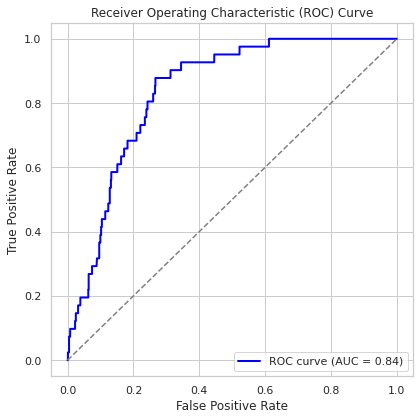

In [0]:
# Collect prediction and probability to driver
preds = predictions.select("stroke", "prediction", "probability").collect()

# Extract labels and predictions
y_true = [int(row["stroke"]) for row in preds]
y_pred = [int(row["prediction"]) for row in preds]
y_scores = [float(row["probability"][1]) for row in preds]  # Probability of class 1

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 360x360 with 0 Axes>

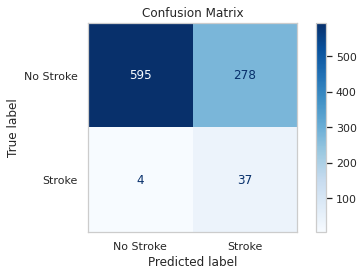

In [0]:
# Get predictions and labels
y_pred = [int(row["prediction"]) for row in preds]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Plot
plt.figure(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

### How do I know the best features?

In [0]:
feature_names = final_assembler.getInputCols()

In [0]:
# After fitting your model (e.g. rf_model = rf.fit(train_data))
importances = rf_model.featureImportances.toArray()

# Zip feature names with their importance
for name, score in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {score:.6f}")

ever_married_index: 0.056829
smoking_status_ohe: 0.022283
gender_index: 0.016512
work_type_ohe: 0.014703
scaled_numeric_vector: 0.013932
Residence_type_index: 0.008442
